In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import layers

from modules.dataset import OneHotProtDataset, AntibodyOneHotProtDataset
from modules.layers import SamplingLayer
from sklearn.model_selection import train_test_split

from modules.models.VAE import VAE

import matplotlib.pyplot as plt

2025-09-03 17:39:42.399475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
plt.style.use('seaborn-v0_8')

In [3]:
x_data, y_data, vector_size, alphabet_size = AntibodyOneHotProtDataset.get_data(200)
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

### Encoder

In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(vector_size, alphabet_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = SamplingLayer()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 22, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 11, 32)  320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 50, 6, 64)    18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 19200)        0           ['conv2d_1[0][0]']         

2025-09-03 17:39:48.284768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Decoder

In [5]:
# Define decoder model. should have output shape (vector_size, alphabet_size, 1)

inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(vector_size // 2 * alphabet_size // 2 * 64, activation="relu")(inputs)
x       = layers.Reshape((vector_size // 2, alphabet_size // 2, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
# x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 70400)             211200    
                                                                 
 reshape (Reshape)           (None, 100, 11, 64)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 100, 11, 64)      36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 200, 22, 64)      36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 200, 22, 1)       577 

## Train the VAE

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
dataset = np.concatenate([x_train, x_test], axis=0)

In [7]:
%%time
vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(dataset, epochs=150, batch_size=128)


2025-09-03 17:39:57.912463: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 28089600 exceeds 10% of free system memory.


Epoch 1/150


2025-09-03 17:39:58.645314: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 36044800 exceeds 10% of free system memory.
2025-09-03 17:39:58.669838: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 36044800 exceeds 10% of free system memory.
2025-09-03 17:39:58.670058: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 27878400 exceeds 10% of free system memory.
2025-09-03 17:39:58.812513: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 144179200 exceeds 10% of free system memory.


13/13 [==============================] - 13s 948ms/step - loss: 2764.3356 - reconstruction_loss: 2227.0923 - kl_loss: 73.1107
Epoch 2/150
13/13 [==============================] - 12s 926ms/step - loss: 924.2564 - reconstruction_loss: 860.5718 - kl_loss: 25.8273
Epoch 3/150
13/13 [==============================] - 12s 925ms/step - loss: 828.9620 - reconstruction_loss: 805.9496 - kl_loss: 7.7658
Epoch 4/150
13/13 [==============================] - 12s 919ms/step - loss: 782.5053 - reconstruction_loss: 768.5084 - kl_loss: 6.0817
Epoch 5/150
13/13 [==============================] - 12s 922ms/step - loss: 746.0598 - reconstruction_loss: 734.5541 - kl_loss: 6.4100
Epoch 6/150
13/13 [==============================] - 12s 907ms/step - loss: 718.1297 - reconstruction_loss: 706.6199 - kl_loss: 6.7967
Epoch 7/150
13/13 [==============================] - 12s 920ms/step - loss: 698.4228 - reconstruction_loss: 687.7872 - kl_loss: 6.7216
Epoch 8/150
13/13 [==============================] - 12s 914ms/

In [8]:
vae.save(f'run/vae-one-hot-{vector_size}.keras')

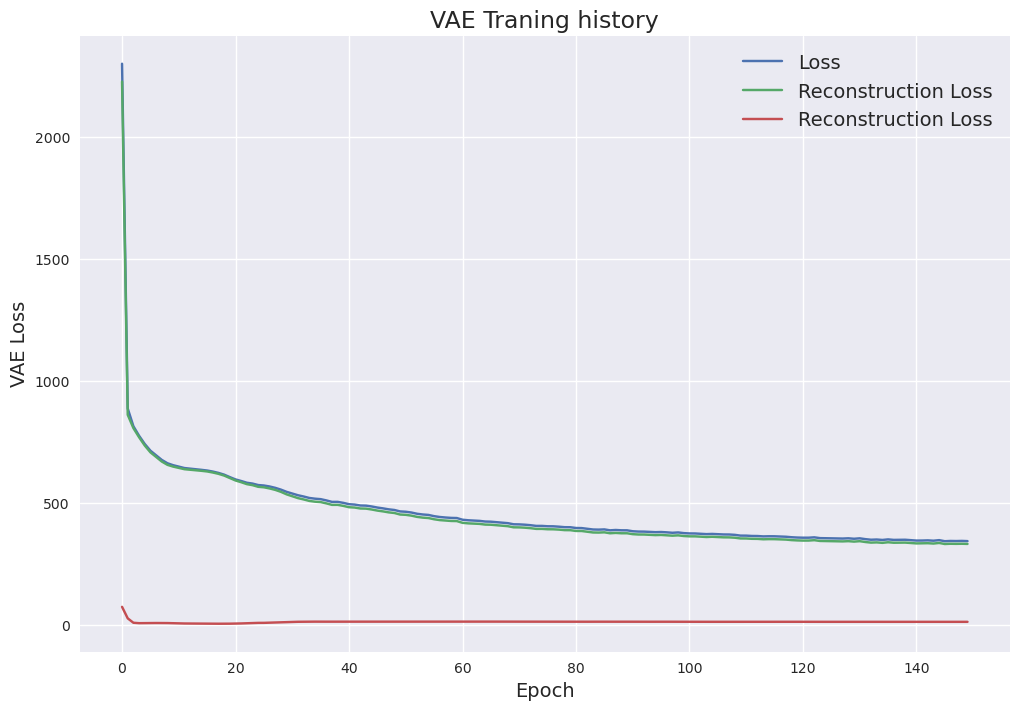

In [29]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["reconstruction_loss"], label = "Reconstruction Loss")
plt.plot(history.history["kl_loss"], label = "Reconstruction Loss")
plt.xlabel("Epoch", fontsize = 14)
plt.ylabel("VAE Loss", fontsize = 14)
plt.title("VAE Traning history", fontsize = 17)
plt.legend(fontsize = 14)
plt.savefig('../plots/VAE_training_curve.png')
plt.show()


## References

- <https://keras.io/examples/generative/vae/>